In [1]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [2]:
#Loading Data
data = pd.read_csv('/Users/anprahlad/Desktop/MachineLearning/StockMarketPredictionEngine/StockPrices.csv')
data.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
0,1-Nov-16,8653.15,8669.60,8614.50,8626.25,170068995,8441.30
1,2-Nov-16,8542.80,8549.50,8504.85,8514.00,160130480,7683.07
2,3-Nov-16,8499.85,8537.65,8476.15,8484.95,175773254,7558.06
3,4-Nov-16,8503.60,8504.00,8400.25,8433.75,231783152,11798.48
4,7-Nov-16,8535.75,8535.85,8481.45,8497.05,178070534,8436.70


In [3]:
#Only Data that Matters is Open High Low Close
data = data.drop(['Date', 'Shares Traded', 'Turnover (Rs. Cr)'], axis = 1)
data.head()

,Open,High,Low,Close
0,8653.15,8669.60,8614.50,8626.25
1,8542.80,8549.50,8504.85,8514.00
2,8499.85,8537.65,8476.15,8484.95
3,8503.60,8504.00,8400.25,8433.75
4,8535.75,8535.85,8481.45,8497.05


In [4]:
#Feature Scaling

data['Open'] = StandardScaler().fit_transform(data['Open'].values.reshape(-1,1))
data['High'] = StandardScaler().fit_transform(data['High'].values.reshape(-1,1))
data['Low'] = StandardScaler().fit_transform(data['Low'].values.reshape(-1,1))
data['Close'] = StandardScaler().fit_transform(data['Close'].values.reshape(-1,1))
data.head()


,Open,High,Low,Close
0,-0.828588,-0.854291,-0.821973,-0.860459
1,-0.987195,-1.028058,-0.979457,-1.022144
2,-1.048928,-1.045203,-1.020677,-1.063988
3,-1.043538,-1.093890,-1.129688,-1.137736
4,-0.997328,-1.047808,-1.013065,-1.046559


In [5]:
#Assigning X and Y
X = data.loc[:, data.columns != 'Close']
X_0 = data.loc[:, data.columns == 'Open']
X_1 = data.loc[:, data.columns == 'High']
X_2 = data.loc[:, data.columns == 'Low']
Y = data.loc[:, data.columns == 'Close']

/Users/anprahlad/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:836: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


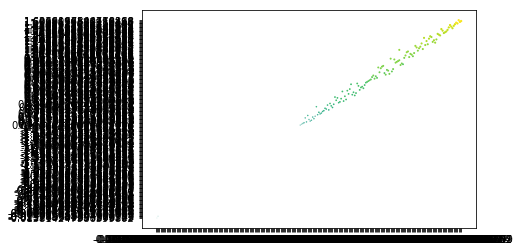

In [6]:
plt.scatter(X_0,X_1, X_2, c = Y )
plt.show()

In [7]:
#Functions
epsilon = 0.01
regularize = 0.01
num_stocks = len(X)
input_dimensionality = 3
output_dimensionality = 1

class Mul:
    def fwd(x, w):
        return np.dot(x, w)
    def back(dL, w, x):
        dW = np.dot(x.T, dL)
        dX = np.dot(dL, w.T)
        return dW, dX
class Add:
    def fwd(wx, b):
        return wx + b
    def back(dL, wx, b):
        dMul = np.ones_like(wx)*dL
        dB = np.dot(np.ones(1, dL.shape[0]), dL)
        return dMul, dB
class ReLu:
    def fwd(z):
        result = np.maximum(0, z)
        cache = z
        return result, cache
    def back(grad, result):
        dz, result = None, cache
        dz = np.array(grad, copy = True)
        dz[result <= 0] = 0
        return dz


In [8]:
#Build Model
def forward(model, x):
    
    W1, b1, W2, b2, = model['W1'], model['b1'], model['W2'], model['b2']
    
    wx1 = Mul.fwd(W1, x)
    z1 = Add.fwd(wx1, b1)
    a1 = ReLu.fwd(z1)
    
    wx2 = Mul.fwd(W2, a1)
    z2 = Add.fwd(wx2, b2)
    a2 = ReLu.fwd(z2)

    return a2

def cost_function(model):
    
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    result = forward(model, x)
    loss = (result[range(num_stocks), y])
    total_loss = np.sum(loss)
    return total_loss / num_stocks

def predict(model, x):
    
    result = forward(model, x)
    return np.argmax(result, axis = 1)

def build(hidden_layer_size, iterations = 10000, print_loss = False):
    np.random.seed(0)
    
    W1 = np.random.randn(input_dimensionality) * np.sqrt(2*input_dimensionality)
    b1 = np.zeros((1, input_dimensionality))
    W2 = np.random.randn(output_dimensionality) * np.sqrt(2*output_dimensionality)
    b2 = np.zeros((1, output_dimensionality))
    
    model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    for i in range(0, iterations):
        
        #Forward
        
        wx1 = Mul.fwd(X, W1)
        z1 = Add.fwd(wx1, b1)
        a1 = ReLu.fwd(z1)
    
        wx2 = Mul.fwd(W2, a1)
        z2 = Add.fwd(wx2, b2)
        a2, cache = ReLu.fwd(z2)

        result = a2
        
        
        #BackProp
        
        z3 = ReLu.back(result, cache)
        dMul2, db2 = Add.back(z3, wx2, b2)
        dW2, dX2 = Mul.back(dMul2, w2, a1)
        
        z = ReLu.back(dW2, dX2)
        dMul, db1 = Add.back(z, wx1, b1)
        dW, dX = Mul.back(dMul, w1, X)
        
        
        #Regularization
        dW2 += regularize*W2
        dW += regularize*W1
        
        #Update Weights
        
        W1 += -epsilon*dW
        b1 += -epsilon*b1
        W2 += -epsilon*W2
        b2 += -epsilon*b2
        
        #Create Model
        
        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        if(print_loss & i % 1000 == 0):
            print("Iteration Complete {}".format(i))
        
    return model

model = build(2, print_loss = "True")


        
        
    
    


ValueError: operands could not be broadcast together with shapes (249,) (1,3) 